# Mapping drought indicator - SPEI VERSION


A simple accepted measure for drought is the Standardized Precipitation Index (SPEI).


https://www.meteoswiss.admin.ch/home/climate/swiss-climate-in-detail/climate-indicators/drought-indices/spi-and-spei.html


https://spei.csic.es/database.html


In [4]:
from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt

import cartopy.crs as ccrs

from scipy import stats

from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC

In [5]:
def area_of_pixel(pixel_size, center_lat):
    """Calculate m^2 area of a wgs84 square pixel.

    Adapted from: https://gis.stackexchange.com/a/127327/2397

    Parameters:
        pixel_size (float): length of side of pixel in degrees.
        center_lat (float): latitude of the center of the pixel. Note this
            value +/- half the `pixel-size` must not exceed 90/-90 degrees
            latitude or an invalid area will be calculated.

    Returns:
        Area of square pixel of side length `pixel_size` centered at
        `center_lat` in m^2.

    """
    a = 6378137  # meters
    b = 6356752.3142  # meters
    e = np.sqrt(1 - (b/a)**2)
    area_list = []
    for f in [center_lat + pixel_size/2, center_lat - pixel_size/2]:
        zm = 1 - e*np.sin(np.radians(f))
        zp = 1 + e*np.sin(np.radians(f))
        area = (np.pi * b**2 * (
                np.log(zp/zm) / (2*e) +
                np.sin(np.radians(f)) / (zp*zm)))
        
        area_list.append(area)
    return (pixel_size / 360.) * (area_list[0] - area_list[1])

In [6]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['figure.figsize'] = (5, 2.7)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['savefig.bbox'] = 'tight'

In [7]:
# REFERENCE_YEAR_START = 1986
# REFERENCE_YEAR_END = 2005

REFERENCE_YEAR_START = 1950
REFERENCE_YEAR_END = 1980

#CRU data is one year behind ERA5
MAX_YEAR = 2020

POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'

RESULTS_FOLDER = Path('../results/drought')

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'drought'/ 'results_2021'

# 'Severity X or worse'
MILD_DROUGHT_THRESHOLD = -0.5
MODERATE_DROUGHT_THRESHOLD = -0.8
SEVERE_DROUGHT_THRESHOLD = -1.3
EXTREME_DROUGHT_THRESHOLD = -1.6
EXCEPTIONAL_DROUGHT_THRESHOLD = -2

DROUGHT_THRESHOLDS = [MILD_DROUGHT_THRESHOLD, MODERATE_DROUGHT_THRESHOLD, SEVERE_DROUGHT_THRESHOLD, EXTREME_DROUGHT_THRESHOLD, EXCEPTIONAL_DROUGHT_THRESHOLD]

DROUGHT_THRESHOLDS_NAMES = ['MILD DROUGHT', 'MODERATE DROUGHT','SEVERE DROUGHT','EXTREME DROUGHT', 'EXCEPTIONAL DROUGHT']

SPEI_INPUT_FILE = INTERMEDIATE_RESULTS_FOLDER / 'spei01.nc'


In [8]:
MAP_PROJECTION = ccrs.EckertIII()

In [9]:
# PIXEL_SIZE = 0.5
PIXEL_SIZE = 1.0

In [10]:
def plot_events_map(plot_data, ax=None):
    plot_data = plot_data.where(plot_data > 0)
    plot_data.name = 'N droughts'

    if ax is None:
        f, ax = plt.subplots(subplot_kw=dict(projection=MAP_PROJECTION), constrained_layout=True)
    
    plot_data.plot.pcolormesh(
        cmap='plasma',
        transform=ccrs.PlateCarree(),
        cbar_kwargs={'orientation':'horizontal','label':''},
        ax=ax
    )
    ax.coastlines()
    return ax

# Load SPEI data

In [11]:
spei = xr.open_dataarray(SPEI_INPUT_FILE,
                         chunks={'time': 12}
                        )

In [12]:
spei = spei.rename({'lat': 'latitude', 'lon': 'longitude'})
spei

<xarray.DataArray 'spei' (time: 854, latitude: 180, longitude: 360)>
dask.array<open_dataset-fc9e6e38cd71688121473cb989457263spei, shape=(854, 180, 360), dtype=float32, chunksize=(12, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-02-01
Attributes:
    units:      standardized values
    long_name:  standardized precipitation-evapotranspiration index

In [13]:
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(spei.latitude))

In [14]:
SPEI_INPUT_FILE_CRU = DATA_SRC / 'lancet'/ 'drought'/ 'results_2020' / 'spei01.nc'


In [15]:
spei_cru = xr.open_dataarray(SPEI_INPUT_FILE_CRU,
                         chunks={'time': 12}
                        )

In [16]:
_cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(spei_cru.lat))
spei_cru_mean = ((spei_cru.sel(time=slice('1950',None)) * _cos_lat)
                 .mean(dim=['lat', 'lon'])
                 .compute())

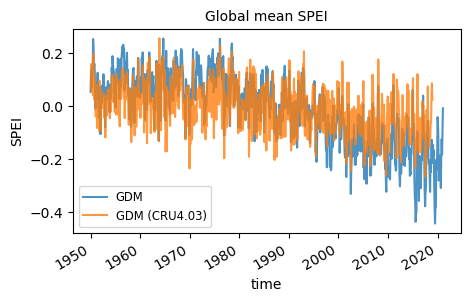

In [14]:
(spei * cos_lat).mean(dim=['latitude', 'longitude']).plot(alpha=0.8, label='GDM')
spei_cru_mean.plot(alpha=0.8, label='GDM (CRU4.03)')
plt.legend()

plt.ylabel('SPEI')
plt.title('Global mean SPEI')
plt.savefig(RESULTS_FOLDER / 'global_mean_spei_old_new.png')
plt.savefig(RESULTS_FOLDER / 'global_mean_spei_old_new.pdf')

## Get a land mask

In [17]:
# For now just take the cells where spei is finite
mask = np.isfinite(spei.isel(time=10, drop=True)).load()


## Calculate areas per grid cell

In [18]:
# # Calculate grid cell areas
# delta_lon = spi6.lon[1] - spi6.lon[0]
# earth_radius = 6371

# areas = (np.sin(np.radians(spi6.lat.values + 0.25))
#  - np.sin(np.radians(spi6.lat.values - 0.25))) * (np.radians(delta_lon.values)) * earth_radius**2



# Areas in km2 - calculation is in m2
areas = area_of_pixel(PIXEL_SIZE, spei.latitude.values) / (1000*1000)
areas = xr.DataArray(areas, dims=['latitude'], coords={'latitude': spei.latitude})

In [19]:
# Calculate total earth surface area using same pixel definition
total_earth_area = (len(spei.longitude) * areas.sum()).item()

In [20]:
total_land_area = (mask * areas).sum().item()

In [21]:
total_land_area/ 1e6

150.34229443647004

In [22]:
144179977 / 1e6

144.179977

In [23]:
# Its a bit off :/
(total_land_area / total_earth_area)

0.29475088701137026

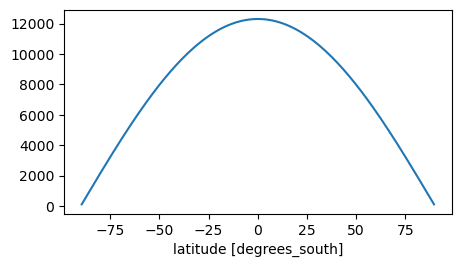

In [24]:
areas.plot()

# Calculate the number of months where the SPI dropped below the threshold for drought

In [25]:
def calc_droughs(spi):
    drought_counts = xr.concat(
        [spi < threshold for threshold in DROUGHT_THRESHOLDS],
        dim=pd.Index(DROUGHT_THRESHOLDS, 
                     name='spei_threshold')
    )
    drought_counts = (drought_counts
                      .groupby('time.year')
                      .sum(dim='time')
                      .astype(np.float32)
                      .compute()
                      .assign_coords(drought_severity=('spei_threshold', 
                                                       DROUGHT_THRESHOLDS_NAMES
                                                      ))
                     )
    drought_counts.name = 'N droughts'
    return drought_counts

## Apply to SPEI

In [26]:
spei = spei.reindex(latitude=list(reversed(spei.latitude))).compute()

In [27]:
drought_levels = xr.concat(
        [spei < threshold for threshold in DROUGHT_THRESHOLDS],
        dim=pd.Index(DROUGHT_THRESHOLDS, 
                     name='spei_threshold')
    ).compute()

drought_levels = drought_levels.assign_coords(drought_severity=('spei_threshold', 
                                                       DROUGHT_THRESHOLDS_NAMES
                                                      ))

In [ ]:
drought_counts = calc_droughs(spei)

drought_counts = drought_counts.where(mask)

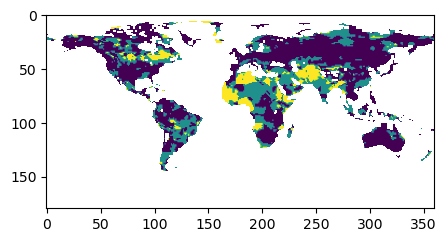

In [31]:
# Double check the underlying data orientation is correct by comparing the
# XR plot with the raw data plot
plt.imshow(drought_counts.isel(year=-1, spei_threshold=1).data)

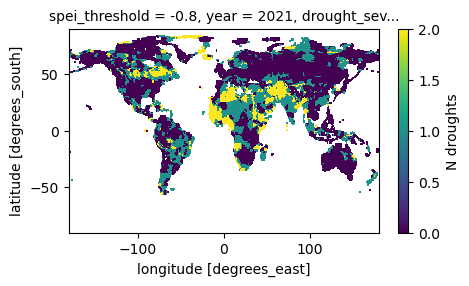

In [32]:
drought_counts.isel(year=-1, spei_threshold=1).plot()

## Map plot combined drought counts

> Select just a few years for example

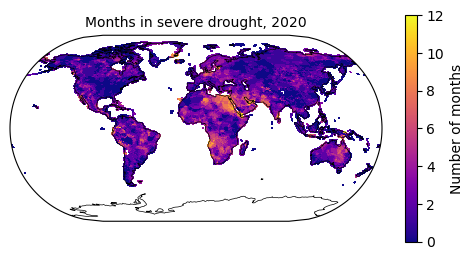

In [33]:
f = plt.figure(figsize=(6,3))

plot_data = drought_counts.sel(year=2018, spei_threshold=SEVERE_DROUGHT_THRESHOLD)

ax = plt.axes(projection=MAP_PROJECTION)

plot_data.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
#     add_colorbar=False,
    cbar_kwargs=dict(label='Number of months'),
        cmap='plasma',
    vmin=0, vmax=12
)
ax.coastlines(linewidth=0.5)
ax.set(title=f'Months in severe drought, {MAX_YEAR}')
# plt.tight_layout()

f.savefig(RESULTS_FOLDER/ f'map spei droughts thrsh -1.3 {MAX_YEAR}.png')
f.show()


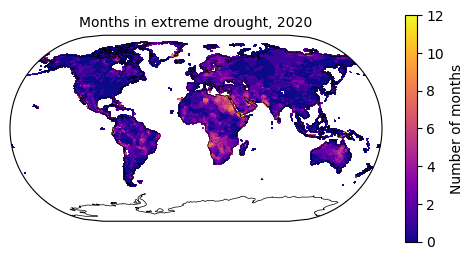

In [34]:
f = plt.figure(figsize=(6,3))

plot_data = drought_counts.sel(year=2018, spei_threshold=EXTREME_DROUGHT_THRESHOLD)

ax = plt.axes(projection=MAP_PROJECTION)

plot_data.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
#     add_colorbar=False,
    cbar_kwargs=dict(label='Number of months'),
        cmap='plasma',
    vmin=0, vmax=12
)
ax.coastlines(linewidth=0.5)
ax.set(title=f'Months in extreme drought, {MAX_YEAR}')
# plt.tight_layout()

f.savefig(RESULTS_FOLDER/ f'map spei droughts thrsh -1.6 {MAX_YEAR}.png')
f.show()


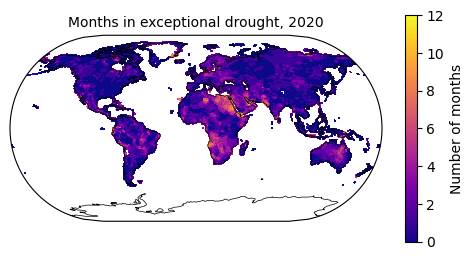

In [35]:
f = plt.figure(figsize=(6,3))

plot_data = drought_counts.sel(year=2018, spei_threshold=EXTREME_DROUGHT_THRESHOLD)

ax = plt.axes(projection=MAP_PROJECTION)

plot_data.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
#     add_colorbar=False,
    cbar_kwargs=dict(label='Number of months'),
        cmap='plasma',
    vmin=0, vmax=12
)
ax.coastlines(linewidth=0.5)
ax.set(title=f'Months in exceptional drought, {MAX_YEAR}')
# plt.tight_layout()

f.savefig(RESULTS_FOLDER/ f'map spei droughts thrsh -2 {MAX_YEAR}.png')
f.show()


## % area affected by at least one drought

In [31]:
drought_levels_ts = drought_levels.astype(int).where(mask) * areas

drought_levels_ts = (drought_levels_ts
                   .sum(dim=['latitude', 'longitude'])
                   .to_dataframe(name='km2')
                   .reset_index()
                   .set_index(['drought_severity', 'time'])['km2']
                   .unstack().T
                  )

# Overkill categorical columns :P
drought_levels_ts.columns = drought_levels_ts.columns.astype(
    pd.CategoricalDtype(DROUGHT_THRESHOLDS_NAMES, ordered=True))

drought_levels_ts = drought_levels_ts.sort_index(axis=1, ascending=True)

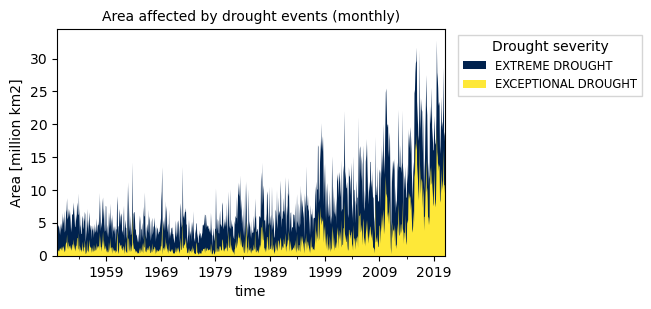

In [33]:
# drought_area_ts = drought_area_ts.sort_index(axis=1, ascending=False)
f, ax = plt.subplots(figsize=(5, 3))
plot_data = (drought_levels_ts / 1e6)
plot_data = plot_data[DROUGHT_THRESHOLDS_NAMES[3:]]
plot_data = plot_data.loc['1950':str(MAX_YEAR)]

plot_data.plot.area(stacked=False, linewidth=0, colormap='cividis', alpha=1,
                                                  legend=False,
                                                  ax=ax, label='Drought severity')
ax.legend(title='Drought severity', bbox_to_anchor=(1.02,1), loc="upper left", fancybox=False)
ax.set(
    title='Area affected by drought events (monthly)',
    ylabel = 'Area [million km2]')

f.savefig(RESULTS_FOLDER / 'drought_area_spei_monthly.png')
f.savefig(RESULTS_FOLDER / 'drought_area_spei_monthly.pdf')

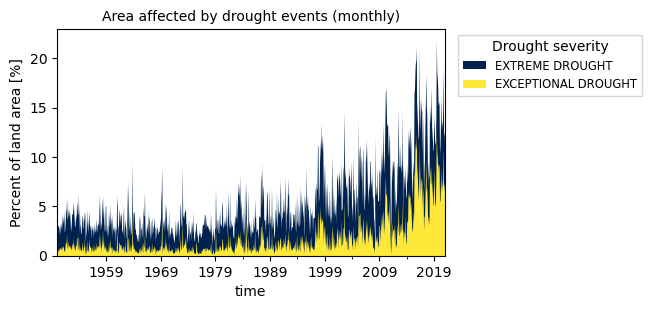

In [34]:
# drought_area_ts = drought_area_ts.sort_index(axis=1, ascending=False)
f, ax = plt.subplots(figsize=(5, 3))
plot_data = (100*drought_levels_ts / total_land_area)
plot_data = plot_data[DROUGHT_THRESHOLDS_NAMES[3:]]
plot_data = plot_data.loc['1950':str(MAX_YEAR)]

plot_data.plot.area(stacked=False, linewidth=0, colormap='cividis', alpha=1,
                                                  legend=False,
                                                  ax=ax, label='Drought severity')
ax.legend(title='Drought severity', bbox_to_anchor=(1.02,1), loc="upper left", fancybox=False)
ax.set(
    title='Area affected by drought events (monthly)',
    ylabel = 'Percent of land area [%]')

f.savefig(RESULTS_FOLDER / 'drought_pct_spei_monthly.png')
f.savefig(RESULTS_FOLDER / 'drought_pct_spei_monthly.pdf')

In [39]:
plot_data.to_csv(RESULTS_FOLDER / 'drought_pct_spei_monthly.csv')

In [41]:
plot_data.loc['1986':'2005'].mean()

drought_severity
SEVERE DROUGHT         11.414370
EXTREME DROUGHT         5.571284
EXCEPTIONAL DROUGHT     1.561109
dtype: float64

In [48]:
plot_data.loc['2020']['EXTREME DROUGHT'].max()

19.11506463389468

In [8]:
plot_data = pd.read_csv(RESULTS_FOLDER / 'drought_pct_spei_monthly.csv')

' '.join(plot_data.sort_values('SEVERE DROUGHT', ascending=False).head(10).time.values)


'2019-06-01 2015-10-01 2015-09-01 2016-04-01 2015-08-01 2015-07-01 2017-07-01 2019-07-01 2020-09-01 2019-09-01'

In [36]:
plot_data = pd.read_csv(RESULTS_FOLDER / 'drought_pct_spei_monthly.csv')
plot_data.time = plot_data.time.astype(np.datetime64)
plot_data = plot_data.set_index('time')
plot_data = plot_data.resample('1Y').max()

# plot_data.sort_values('SEVERE DROUGHT', ascending=False).head(10)
plot_data

SEVERE DROUGHT  EXTREME DROUGHT  EXCEPTIONAL DROUGHT
time                                                            
1950-12-31       11.622769         6.647545             2.324718
1951-12-31       10.643725         5.870837             2.217142
1952-12-31       11.025323         5.439683             1.716754
1953-12-31       11.106360         6.341167             2.365156
1954-12-31        9.857683         4.800694             1.469321
...                    ...              ...                  ...
2016-12-31       27.936015        20.846157            11.609165
2017-12-31       27.024370        18.337630             9.917222
2018-12-31       24.783809        17.057975             9.167614
2019-12-31       29.398475        21.830438            13.110085
2020-12-31       26.664771        19.115065            10.876934

[71 rows x 3 columns]

In [59]:
plot_data = pd.read_csv(RESULTS_FOLDER / 'drought_pct_spei_monthly.csv')

plot_data.time = plot_data.time.astype(np.datetime64)
plot_data = plot_data.set_index('time')
plot_data = plot_data.resample('10Y', closed='left').max()

In [45]:
plot_data = pd.read_csv(RESULTS_FOLDER / 'drought_pct_spei_monthly.csv')
plot_data.time = plot_data.time.astype(np.datetime64)
plot_data = plot_data.set_index('time')

In [58]:
plot_data[:'2019'].resample('10Y', closed='left').max()

SEVERE DROUGHT  EXTREME DROUGHT  EXCEPTIONAL DROUGHT
time                                                            
1959-12-31       11.730267         6.647545             2.521849
1969-12-31       15.225922         9.491002             4.380525
1979-12-31       13.133194         9.028924             3.682782
1989-12-31       15.526550         9.475894             3.645554
1999-12-31       23.115598        13.471551             5.007823
2009-12-31       25.441880        14.683621             5.940479
2019-12-31       29.398475        21.830438            13.110085

# Calculate Mean and SD of droughts during baseline period and plot relative to this

The idea is that we care about events that are more unusual also relative to the typical variation. So if we consider the 'normal' spread of drought events during the reference period, then we want to see what areas are in the extreme ranges of this.


In [98]:
REFERENCE_YEAR_START = 1950
REFERENCE_YEAR_END = 2005

In [99]:
drought_counts_mean = drought_counts.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year').compute()
drought_counts_std = drought_counts.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).std(dim='year').compute()

In [101]:
drought_over_2std = (drought_counts > (drought_counts_mean + 2*drought_counts_std)).astype(int)
drought_over_2std = drought_over_2std.where(mask)

## Plot events where the count is over 2 SD above the mean

> Showing only data every few years to avoid overloading the browser

In [38]:
import matplotlib.colors as colors

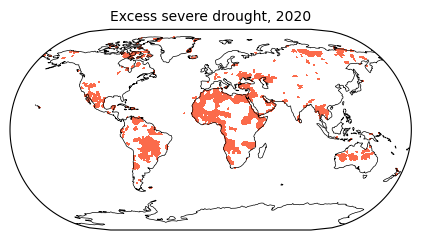

In [102]:
plot_data = drought_over_2std.sel(year=MAX_YEAR,spei_threshold=SEVERE_DROUGHT_THRESHOLD)
plot_data = plot_data.where(plot_data >0)

f, ax = plt.subplots(figsize=(6,2.5), subplot_kw=dict(projection=MAP_PROJECTION))

plot_data.plot.contourf(
    ax=ax,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
        cmap='Reds_r',
)
ax.coastlines(linewidth=0.5)
ax.set(title=f'Excess severe drought, {MAX_YEAR}')
ax.set_global()

plt.tight_layout()

f.savefig(RESULTS_FOLDER/f'map excess drought -1.3 {MAX_YEAR}.png')
f.savefig(RESULTS_FOLDER/f'map excess drought -1.3 {MAX_YEAR}.pdf')

f.show()


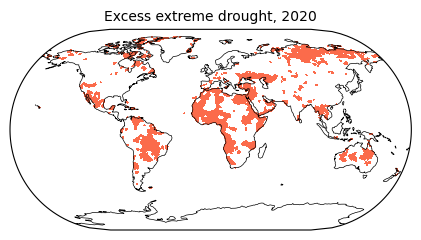

In [50]:
plot_data = drought_over_2std.sel(year=MAX_YEAR,spei_threshold=EXTREME_DROUGHT_THRESHOLD)
plot_data = plot_data.where(plot_data >0)

f, ax = plt.subplots(figsize=(6,2.5), subplot_kw=dict(projection=MAP_PROJECTION))

plot_data.plot.contourf(
    ax=ax,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
        cmap='Reds_r',
)
ax.coastlines(linewidth=0.5)
ax.set(title=f'Excess extreme drought, {MAX_YEAR}')
ax.set_global()

plt.tight_layout()

f.savefig(RESULTS_FOLDER/f'map excess drought -1.6 {MAX_YEAR}.png')
f.savefig(RESULTS_FOLDER/f'map excess drought -1.6 {MAX_YEAR}.pdf')

f.show()


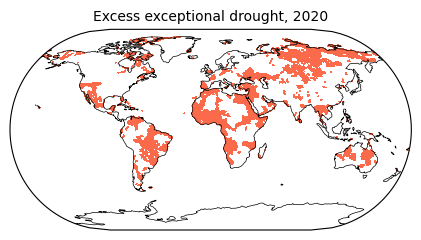

In [52]:
plot_data = drought_over_2std.sel(year=MAX_YEAR,spei_threshold=EXCEPTIONAL_DROUGHT_THRESHOLD)
plot_data = plot_data.where(plot_data >0)

f, ax = plt.subplots(figsize=(6,2.5), subplot_kw=dict(projection=MAP_PROJECTION))

plot_data.plot.contourf(
    ax=ax,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
        cmap='Reds_r',
)
ax.coastlines(linewidth=0.5)
ax.set(title=f'Excess exceptional drought, {MAX_YEAR}')
ax.set_global()

plt.tight_layout()

f.savefig(RESULTS_FOLDER/f'map exceptional drought -2 {MAX_YEAR}.png')
f.savefig(RESULTS_FOLDER/f'map exceptional drought -2 {MAX_YEAR}.pdf')

f.show()


In [43]:
drought_over_2std.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / 'drought_excess_spei 1950-2006 baseline.nc')

### Area excess drought

In [103]:
drought_area_ts_2sd = drought_over_2std * areas

drought_area_ts_2sd = (drought_area_ts_2sd
                   .sum(dim=['latitude', 'longitude'])
                   .to_dataframe(name='km2')
                   .reset_index()
                   .set_index(['drought_severity', 'year'])['km2']
                   .unstack().T
                  )
# Overkill categorical columns :P
drought_area_ts_2sd.columns = drought_area_ts_2sd.columns.astype(
    pd.CategoricalDtype(DROUGHT_THRESHOLDS_NAMES, ordered=True))

drought_area_ts_2sd = drought_area_ts_2sd.sort_index(axis=1, ascending=True)

In [107]:
total_land_area

150342294.43647003

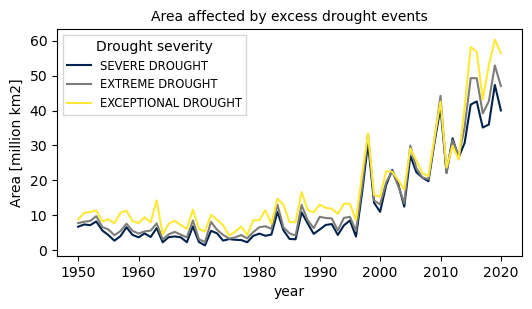

In [105]:
# drought_area_ts = drought_area_ts.sort_index(axis=1, ascending=False)
f, ax = plt.subplots(figsize=(6, 3))
plot_data = (drought_area_ts_2sd / 1e6)
plot_data = plot_data[DROUGHT_THRESHOLDS_NAMES[2:]]

plot_data = plot_data.loc[1950:MAX_YEAR]

plot_data.plot(
#     stacked=False, 
#     linewidth=0, 
    colormap='cividis', alpha=1,
    ax=ax,
    legend=False
)

ax.legend(title='Drought severity',
#           bbox_to_anchor=(1.02,1), loc="upper left", 
          fancybox=False
         )
ax.set(title='Area affected by excess drought events',
       ylabel = 'Area [million km2]')

f.savefig(RESULTS_FOLDER / 'drought_excess_area_spei 1950-2005 baseline.png')
f.savefig(RESULTS_FOLDER / 'drought_excess_area_spei 1950-2005 baseline.pdf')

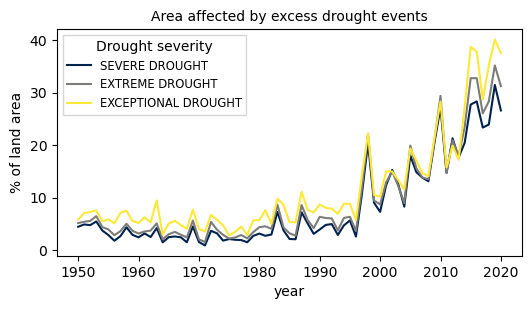

In [106]:
# drought_area_ts = drought_area_ts.sort_index(axis=1, ascending=False)
f, ax = plt.subplots(figsize=(6, 3))
plot_data = (100*drought_area_ts_2sd / total_land_area)
plot_data = plot_data[DROUGHT_THRESHOLDS_NAMES[2:]]

plot_data = plot_data.loc[1950:MAX_YEAR]

plot_data.plot(
#     stacked=False, 
#     linewidth=0, 
    colormap='cividis', alpha=1,
    ax=ax,
    legend=False
)

ax.legend(title='Drought severity',
#           bbox_to_anchor=(1.02,1), loc="upper left", 
          fancybox=False
         )
ax.set(title='Area affected by excess drought events',
       ylabel = '% of land area')

f.savefig(RESULTS_FOLDER / 'drought excess pct area spei 1950-2005 baseline.png')
f.savefig(RESULTS_FOLDER / 'drought excess pct area spei 1950-2005 baseline.pdf')

In [48]:
drought_area_ts_2sd.to_csv(RESULTS_FOLDER / 'drought_excess_total_area_spei 1950-2005 baseline.csv')

(drought_area_ts_2sd / total_land_area).to_csv(RESULTS_FOLDER / 'drought_excess_percent_area_spei 1950-2005 baseline.csv')